In [6]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.optim.lr_scheduler as lr_scheduler

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=True)

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [9]:
# figure = plt.figure()
# num_of_images = 127
# for index in range(1, num_of_images + 1):
#     plt.subplot(8, 16, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [10]:
def create_model():
    input_size = 784
    hidden_sizes = [512, 512, 256, 256]
    output_size = 10

    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[3], output_size),
                        nn.LogSoftmax(dim=1))
    # print(model)
    return model
model = create_model()
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=10, bias=True)
  (9): LogSoftmax(dim=1)
)


In [11]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-6.9772e-05, -6.9772e-05, -6.9772e-05,  ..., -6.9772e-05,
         -6.9772e-05, -6.9772e-05],
        [ 2.1226e-04,  2.1226e-04,  2.1226e-04,  ...,  2.1226e-04,
          2.1226e-04,  2.1226e-04],
        [ 1.6036e-04,  1.6036e-04,  1.6036e-04,  ...,  1.6036e-04,
          1.6036e-04,  1.6036e-04],
        ...,
        [ 1.2870e-04,  1.2870e-04,  1.2870e-04,  ...,  1.2870e-04,
          1.2870e-04,  1.2870e-04],
        [ 8.1972e-05,  8.1972e-05,  8.1972e-05,  ...,  8.1972e-05,
          8.1972e-05,  8.1972e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


In [12]:
def training(lr,epochs, start_factor=1, end_factor=1, momentum=0.9, dampening=0.0):
    # lr=0.01
    # momentum=0.99
    # dampening=0.001
    # epochs = 30
    optimizer = optim.SGD(model.parameters(), lr, momentum, dampening)
    scheduler = lr_scheduler.LinearLR(optimizer, start_factor, end_factor, total_iters=epochs)

    running_losses = []  # List to store losses for each epoch
    time_per_pass = []
    
    time0 = time()
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            if e == 0:
                time_per_pass.append((time()-time0))
            else:
                time_per_pass.append(((time()-timeN)))
            timeN = time()
            epoch_loss = running_loss / len(trainloader)
            running_losses.append(epoch_loss)
        
        # lr=lr*0.8
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("Epoch {} - Training loss: {} - time taken: {} - Learning Rate: {}".format(e, epoch_loss,time_per_pass[e],before_lr))
        # print("Epoch %d: SGD lr %.4f -> %.4f" % (e, before_lr, after_lr))
        # print("Epoch %d: momentun %.4f" % (e, optimizer.param_groups[0]["momentum"]))
    # print("\nTraining Time (in minutes) =",(time()-time0)/60)
    return running_losses,time_per_pass, (time()-time0)

times = training(0.1,3)
print(times)

Epoch 0 - Training loss: 0.5622356841400233 - time taken: 15.912020683288574 - Learning Rate: 0.1
Epoch 1 - Training loss: 0.20928402720833383 - time taken: 17.760034322738647 - Learning Rate: 0.1
Epoch 2 - Training loss: 0.14135384463520448 - time taken: 19.228618621826172 - Learning Rate: 0.1
([0.5622356841400233, 0.20928402720833383, 0.14135384463520448], [15.912020683288574, 17.760034322738647, 19.228618621826172], 52.901671171188354)


In [13]:
def accuracy():
  correct_count, all_count = 0, 0
  for images,labels in valloader:
    for i in range(len(labels)):
      img = images[i].view(1, 784)
      with torch.no_grad():
          logps = model(img)

      
      ps = torch.exp(logps)
      probab = list(ps.numpy()[0])
      pred_label = probab.index(max(probab))
      true_label = labels.numpy()[i]
      if(true_label == pred_label):
        correct_count += 1
      all_count += 1

  print("Number Of Images Tested =", all_count)
  print("Model Accuracy =", (correct_count/all_count))
  return (correct_count/all_count)
acc = accuracy()
print(acc)

Number Of Images Tested = 10000
Model Accuracy = 0.9524
0.9524


In [14]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

 Predicted Digit = 8 
 Probability of sucess =  0.9173005 
 True Digit 8


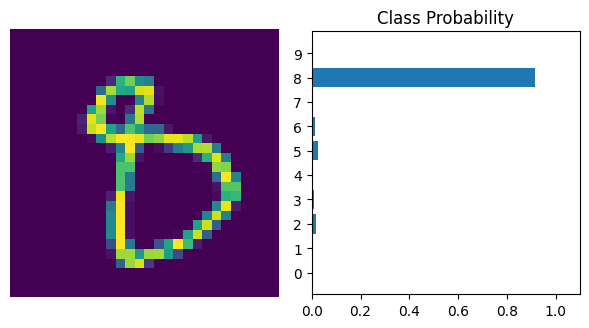

In [16]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
true_label = labels.numpy()[0]
print(" Predicted Digit =", probab.index(max(probab)), "\n", "Probability of sucess = ", probab[probab.index(max(probab))], "\n","True Digit",true_label)
view_classify(img.view(1, 28, 28), ps)

In [24]:
# create table with all datasets possible
data = []  # To store the data for each iteration
df = pd.DataFrame(data)

epoch = 20
lr = 0.01
for i in range(1, 50):  # Avoid division by zero by starting from 1
    criterion = nn.NLLLoss()
    images, labels = next(iter(trainloader))
    images = images.view(images.shape[0], -1)

    logps = model(images) #log probabilities
    loss = criterion(logps, labels) #calculate the NLL loss

    loss.backward()

    model = create_model()
    loss, timepas, total = training(lr*i, epoch,1,1)  # Renamed the variable
    acc = accuracy()
    print("\nEpoch: ",epoch,"\nLearnig Rate: ",lr*i,"\nAccuracy: ", acc, "\nTime Taken: ",total,"\n")
    
    if i == 1:
        df = pd.DataFrame({
            "Learning Rate":lr*i,
            "Running Losses": [loss],  # Assuming training0[0] is a list
            "Time Per Pass": [timepas],   # Assuming training0[1] is a list
            "Total Time": total,      # Assuming training0[2] is a list
            "acc":acc
        }, index=[0])
        # Save the updated DataFrame to the CSV file
        df.to_csv("results.csv", index=False)
    else:
        # Read the existing CSV into a DataFrame
        df = pd.read_csv("results.csv")
        # Create a new row DataFrame
        new_row = pd.DataFrame({
            "Learning Rate":lr*i,
            "Running Losses": [loss],  # Assuming training0[0] is a list
            "Time Per Pass": [timepas],   # Assuming training0[1] is a list
            "Total Time": total,      # Assuming training0[2] is a list
            "acc":acc
        }, index=[0])
        # Concatenate the new row DataFrame to the existing DataFrame
        df = pd.concat([df, new_row], ignore_index=True)
        # Save the updated DataFrame to the CSV file
        df.to_csv("results.csv", index=False)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=True)

Epoch 0 - Training loss: 0.8611626659057288 - time taken: 19.9218966960907 - Learning Rate: 0.01
Epoch 1 - Training loss: 0.21864333203924236 - time taken: 19.459450006484985 - Learning Rate: 0.01
Epoch 2 - Training loss: 0.14336340018172763 - time taken: 19.67315936088562 - Learning Rate: 0.01
Epoch 3 - Training loss: 0.10866316616026832 - time taken: 19.771377086639404 - Learning Rate: 0.01
Epoch 4 - Training loss: 0.09153285377355082 - time taken: 19.347498178482056 - Learning Rate: 0.01
Epoch 5 - Training loss: 0.07509706695494589 - time taken: 19.449846982955933 - Learning Rate: 0.01
Epoch 6 - Training loss: 0.06380085406630341 - time taken: 19.365235328674316 - Learning Rate: 0.01
Epoch 7 - Training loss: 0.057490002236831414 - time taken: 19.7628071308136 - Learning Rate: 0.01
Epoch 8 - Training loss: 0.049818215869875476 - time taken: 19.19812512397766 - Learning Rate: 0.01
Epoch 9 - Training loss: 0.04300370885194269 - time taken: 19.31298828125 - Learning Rate: 0.01
Epoch 10 

In [ ]:
# # Create a DataFrame from the collected data
# df = pd.DataFrame(data)

# # Save the DataFrame to an Excel file (xlsx)
# df.to_excel("results.xlsx", index=False)

In [ ]:

torch.save(model, './my_mnist_model.pt') 